# SEGMENTATION pipeline
## Imports

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.fft import fftn, fftshift

from sklearn import preprocessing
from skimage import segmentation, morphology, measure, feature, filters, color, exposure
from skimage.color import label2rgb
from skimage.filters import difference_of_gaussians, window, meijering, sato, frangi, hessian



## Read image in

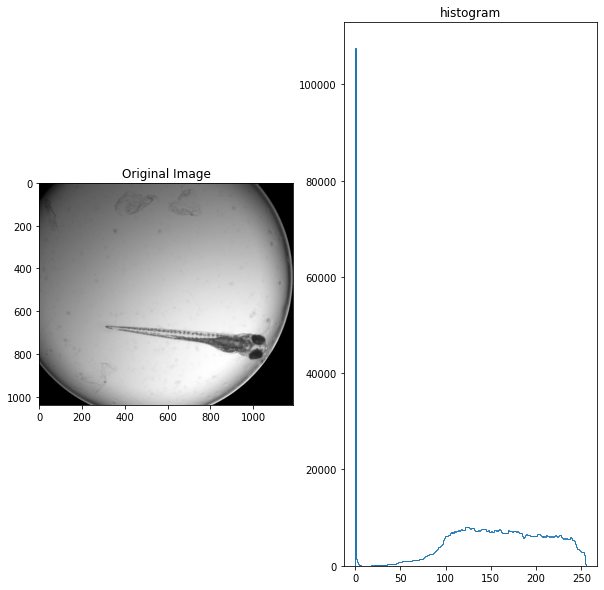

In [97]:
start_img = cv.imread('zfc.jpg', 0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(start_img, cmap='gray')
ax[0].set_title('Original Image')

ax[1].hist(start_img.ravel(), bins=256, histtype='step')
ax[1].set_title('histogram')
plt.show()

## Applying blur

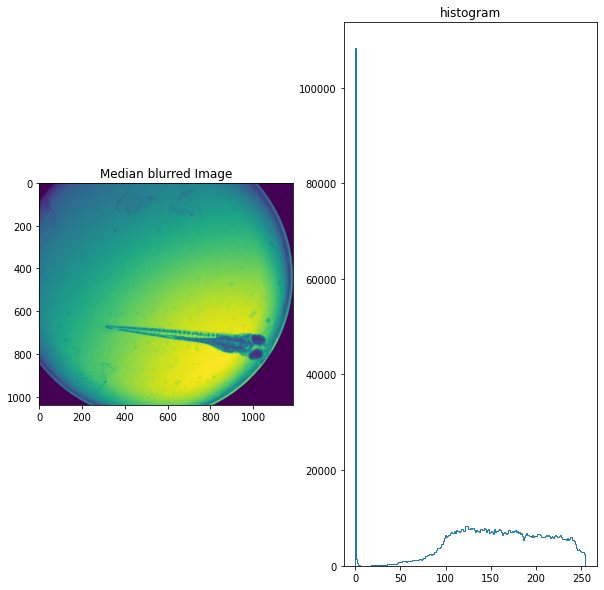

In [98]:
median_blurred = filters.median(start_img, morphology.disk(2))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(median_blurred)
ax[0].set_title('Median blurred Image')

ax[1].hist(median_blurred.ravel(), bins=256, histtype='step')
ax[1].set_title('histogram')
plt.show()

## Trying thresholdings

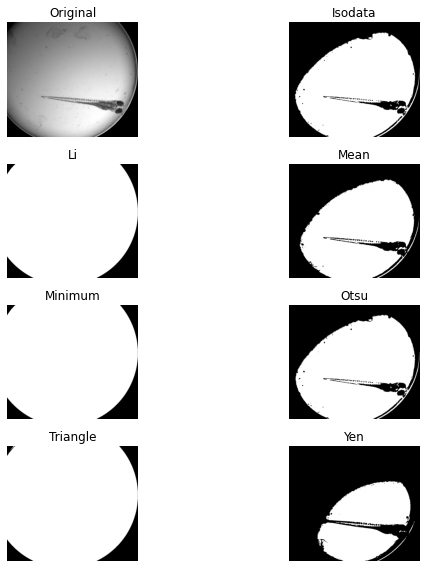

In [99]:
fig, ax = filters.try_all_threshold(median_blurred, figsize=(10, 8), verbose=False)
plt.show()

## DIFFERENCE OF GAUSSIANS


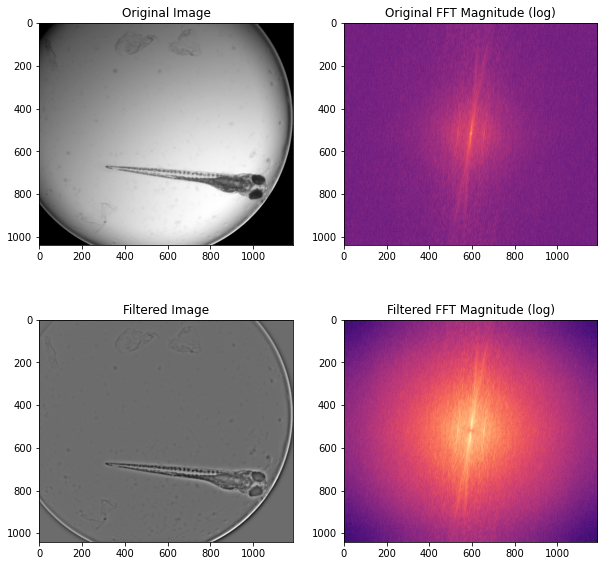

In [100]:
gaussian_diff = median_blurred
window_image = gaussian_diff * window('hann', gaussian_diff.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(gaussian_diff, 1, 10)
filtered_wimage = filtered_image * window('hann', gaussian_diff.shape)
im_f_mag = fftshift(np.abs(fftn(window_image)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0, 0].imshow(gaussian_diff, cmap='gray')
ax[0, 0].set_title('Original Image')
im_f_mag = np.log(im_f_mag)
ax[0, 1].imshow(im_f_mag, cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')

ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')

fim_f_mag = np.log(fim_f_mag)
ax[1, 1].imshow(fim_f_mag, cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')

plt.show()

## Filtered img histogram

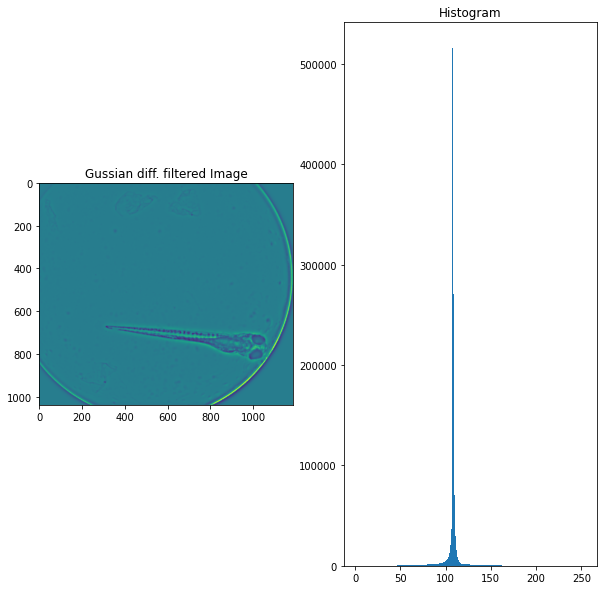

In [101]:
normalized_img = cv.normalize(filtered_image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

ax[0].imshow(filtered_image)
ax[0].set_title('Gussian diff. filtered Image')

ax[1].hist(normalized_img.ravel(), bins=256, histtype='bar')
ax[1].set_title('Histogram')

plt.show()

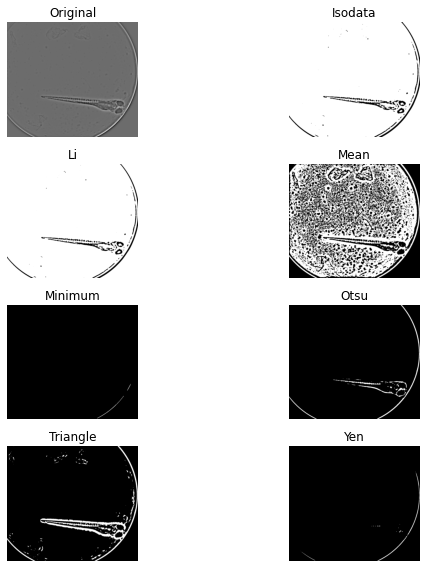

In [102]:
fig, ax = filters.try_all_threshold(filtered_image, figsize=(10, 8), verbose=False)
plt.show()

## Apply triangle thresholding

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

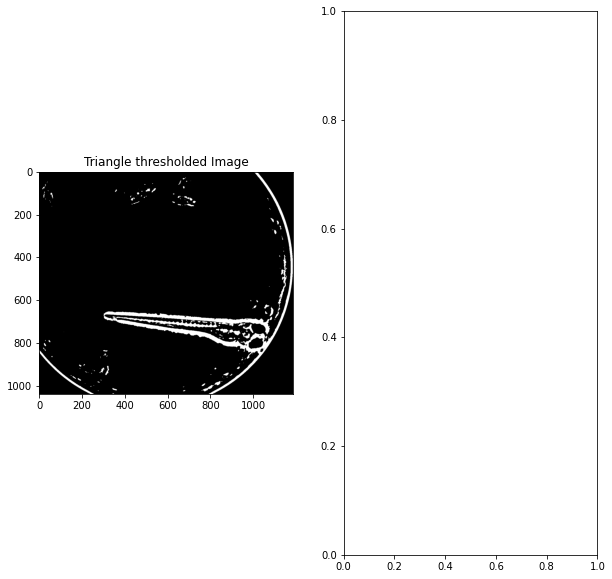

In [103]:
triangle_th = filters.threshold_triangle(normalized_img)

plt.show()
## Filtered img histogram
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

th_img = normalized_img > triangle_th

ax[0].imshow(th_img, 'gray')
ax[0].set_title('Triangle thresholded Image')

print(th_img.astype(int))

ax[1].hist(th_img.ravel(), bins=256, histtype='bar')
ax[1].set_title('Histogram')
plt.show()

Morphological transformations

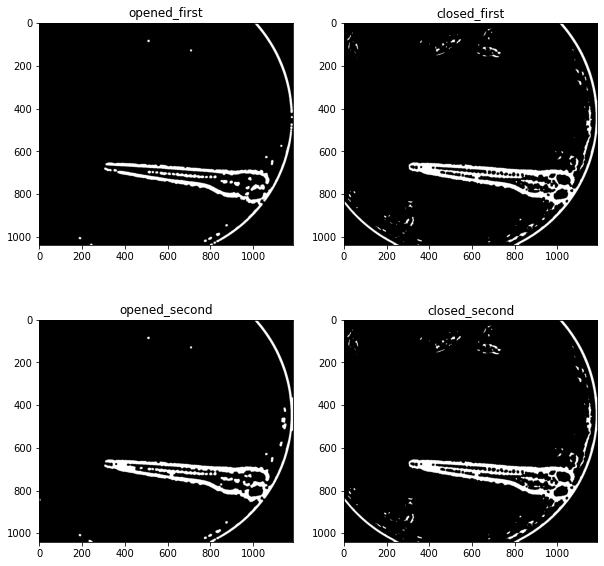

In [153]:
str_elem = morphology.disk(3)
str_elem2 = morphology.disk(5)
str_elem3 = morphology.square(3)

eroded = morphology.erosion(th_img, str_elem3)
dilated = morphology.dilation(th_img, str_elem3)

opened_first = morphology.opening(th_img, str_elem2)
closed_first = morphology.binary_closing(th_img, str_elem2)

opened_second = morphology.opening(closed_first, str_elem2)
closed_second = morphology.closing(closed_first, str_elem2)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(opened_first, 'gray')
ax[0, 0].set_title('opened_first')

ax[0, 1].imshow(closed_first, 'gray')
ax[0, 1].set_title('closed_first')

ax[1, 0].imshow(opened_second, 'gray')
ax[1, 0].set_title('opened_second')

ax[1, 1].imshow(closed_second, 'gray')
ax[1, 1].set_title('closed_second')

plt.show()

closed = closed_first

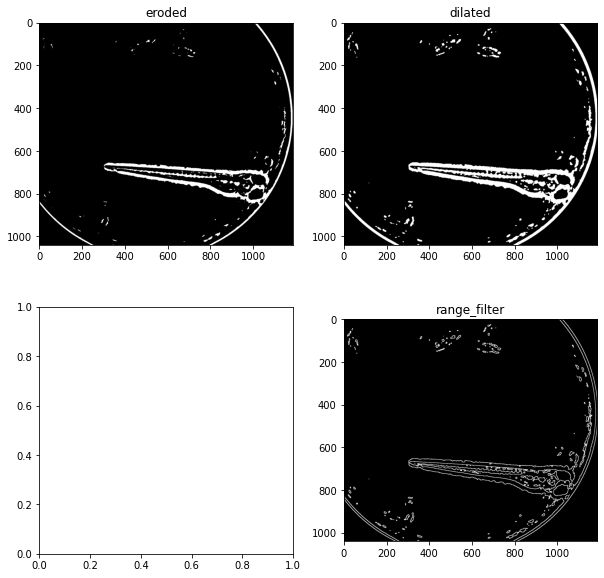

In [154]:
range_filt = dilated ^ eroded

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(eroded, 'gray')
ax[0, 0].set_title('eroded')

ax[0, 1].imshow(dilated, 'gray')
ax[0, 1].set_title('dilated')

ax[1, 1].imshow(range_filt, 'gray')
ax[1, 1].set_title('range_filter')

plt.show()

## Canny

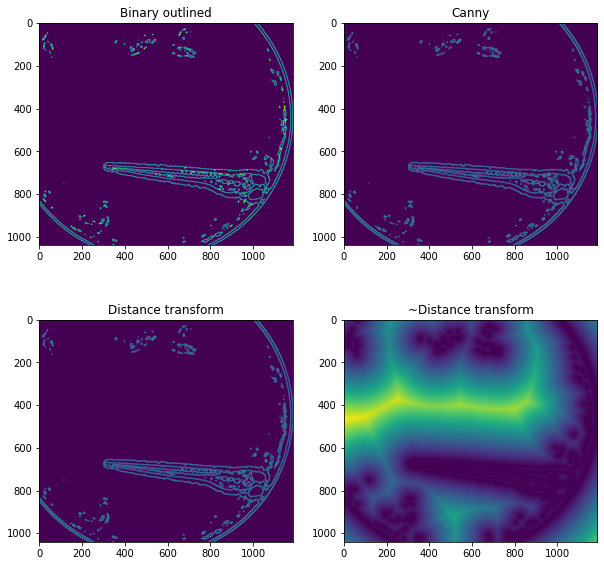

In [158]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(range_filt)
ax[0, 0].set_title('Binary outlined')

cnny = feature.canny(range_filt)

ax[0, 1].imshow(cnny)
ax[0, 1].set_title('Canny')

dt = scipy.ndimage.distance_transform_edt(cnny)
dt_ = scipy.ndimage.distance_transform_edt(~cnny)

ax[1, 0].imshow(dt)
ax[1, 0].set_title('Distance transform')

ax[1, 1].imshow(dt_)
ax[1, 1].set_title('~Distance transform')

plt.show()

## Label & Watershed

bins: 126
mask sizes: 127


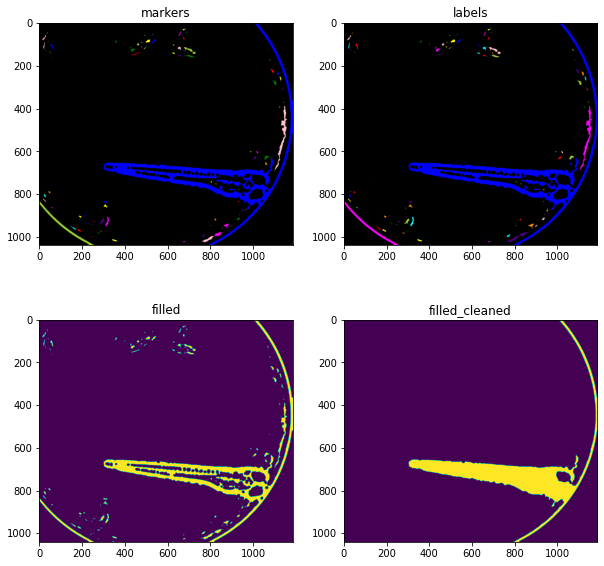

In [229]:
filled = (closed)

labels = measure.label(filled)

markers, _ = scipy.ndimage.label(filled)
print(f'bins: {_}')

sizes = np.bincount(markers.ravel())

size_th = (start_img.size)

mask_sizes = sizes > (size_th * 0.01)
print(f'mask sizes: {mask_sizes.size}')

mask_sizes[0] = 0

filled_cleaned = mask_sizes[markers]
filled_cleaned = scipy.ndimage.binary_fill_holes(filled_cleaned)

labels = label2rgb(labels, bg_label=0)
markers = label2rgb(markers, bg_label=0)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(markers)
ax[0, 0].set_title('markers')

ax[0, 1].imshow(labels)
ax[0, 1].set_title('labels')

ax[1, 0].imshow(filled)
ax[1, 0].set_title('filled')

ax[1, 1].imshow(filled_cleaned)
ax[1, 1].set_title('filled_cleaned')

plt.show()

## Cleaning mask

Text(0.5, 1.0, 'masked')

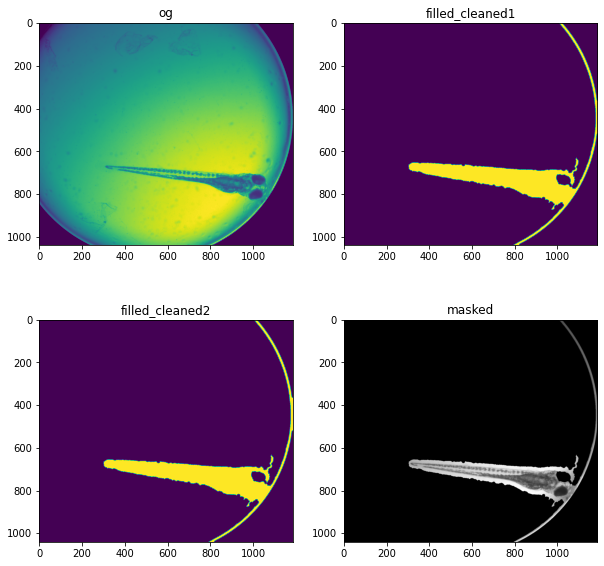

In [230]:
filled_cleaned1 = morphology.area_opening(filled_cleaned, 100)
filled_cleaned2 = morphology.area_closing(filled_cleaned, 10000)

cleaned = filled_cleaned2

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

ax[0, 0].imshow(start_img)
ax[0, 0].set_title('og')

ax[0, 1].imshow(filled_cleaned1)
ax[0, 1].set_title('filled_cleaned1')

ax[1, 0].imshow(filled_cleaned2)
ax[1, 0].set_title('filled_cleaned2')

ax[1, 1].imshow(start_img * filled_cleaned2, 'gray')
ax[1, 1].set_title('masked')


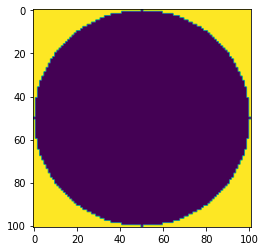

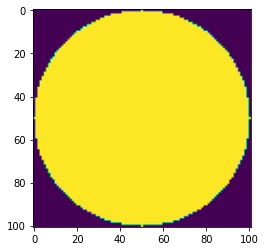

In [238]:
a = morphology.disk(50)
plt.imshow(~a)
plt.show()
plt.imshow(a)
plt.show()
